# SET Classification: Abstractor vs CorelNet

In [230]:
import sys
sys.path.append('../..'); sys.path.append('../');

import numpy as np
import matplotlib.pyplot as plt
from setGame import *
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import utils

In [231]:
setgame = SetGame()

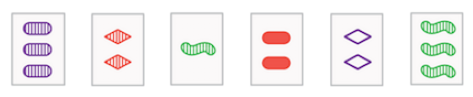

[1 2 5]


In [232]:
num_cards=6
_ = setgame.init_state(num_cards=num_cards, shuffle=False)
hand = setgame.state.dealt_cards
fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
for i in range(len(hand)):
    card = hand[i]
    axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
    axarr[i].axis('off')
plt.show()
print(np.sort(np.argsort(pi)[0:3]))


In [233]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=64):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(self.model.input, self.model.layers[7].output)
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [234]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=64)
cnn.train(X_train, y_train, epochs=50)


Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 70, 50, 4)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 66, 46, 32)        3232      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 7, 32)         25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 1, 32)          0         
 g2D)                                                            
                                                                 
 flatten_134 (Flatten)       (None, 96)                0  

In [236]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]))
    print('\n')

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]


[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]


[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]


[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]




In [237]:
out = cnn.predict(X_test)
pred = np.array(np.round(out), dtype=int)
1-np.sum(pred != y_test) / (np.prod(pred.shape))


1.0

## SET Classification Task

In [238]:
def create_set_classification_dataset(num_seqs):

    vocab_size = 81
    setgame = SetGame()
    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

    # generate random features for each object
    card_images = np.zeros((9, 9, dim))
    for i in range(9):
        for j in range(9):
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()

    object_seqs = np.zeros((num_seqs, 3, dim))
    card_seqs = np.zeros((num_seqs, 3, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)

    for s in np.arange(0, num_seqs, 2):
        _ = setgame.init_state(num_cards=6, shuffle=False)
        hand = setgame.state.dealt_cards
        for i in np.arange(3):
            card = hand[i]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(3):
            card = hand[i+3]
            object_seqs[s+1, i] = card_images[card[0], card[1]]
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    return card_images, card_seqs, labels, object_seqs,

In [239]:
card_images, card_seqs, labels, object_seqs = create_set_classification_dataset(num_seqs=10000)

In [240]:
test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, object_seqs_train, object_seqs_test, labels_train, labels_test = train_test_split(card_seqs, object_seqs, labels, test_size=0.2)

seqs_train, seqs_val, object_seqs_train, object_seqs_val, labels_train, labels_val = \
train_test_split(seqs_train, object_seqs_train, labels_train, test_size=val_size/(1-test_size))

X_train, X_val, X_test = object_seqs_train, object_seqs_val, object_seqs_test
y_train, y_val, y_test = labels_train, labels_val, labels_test

In [241]:
X_train.shape, y_train.shape

((7000, 3, 64), (7000,))

In [243]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

def create_callbacks():
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=50, start_from_epoch=30)]
    return callbacks


## Transformer

In [245]:
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import SymbolicAbstracter, RelationalAbstracter

def create_transformer(num_layers, num_heads, dff, embedding_dim, dropout_rate=0.1,):
    inputs = layers.Input(shape=object_seqs_train.shape[1:])
    source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
    flattener = layers.Flatten()
    final_layer = layers.Dense(2, name='final_layer')

    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    encoder_context = encoder(x)
    output = flattener(encoder_context)
    logits = final_layer(output)

    transformer_model = tf.keras.Model(inputs=inputs, outputs=logits)
    return transformer_model

In [246]:
transformer_model = create_transformer(
    num_layers=2, num_heads=4, dff=64, embedding_dim=64)

transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
transformer_model.summary()
for train_size in [100,200,400,600,1000,2000,3000]:
    transformer_model = create_transformer(num_layers=2, num_heads=4, dff=64, embedding_dim=64)
    transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    history =  transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, callbacks=create_callbacks())
    transformer_model.evaluate(X_test, y_test)

Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 3, 64)]           0         
                                                                 
 source_embedder (TimeDistr  (None, 3, 64)             4160      
 ibuted)                                                         
                                                                 
 add_pos_embedding_input (A  (None, 3, 64)             0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           (None, 3, 64)             149888    
                                                                 
 flatten_135 (Flatten)       (None, 192)               0         
                                                                 
 final_layer (Dense)         (None, 2)                 386

In [210]:
Transformer_model = create_transformer(
    num_layers=2, num_heads=4, dff=64, embedding_dim=64)

transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
train_size = 1000
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=create_callbacks())

Epoch 1/100
32/32 [==============================] - 2s 13ms/step - loss: 1.1974 - acc: 0.5050 - val_loss: 0.7445 - val_acc: 0.4860
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7022 - acc: 0.5340 - val_loss: 0.6909 - val_acc: 0.5270
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6933 - acc: 0.5500 - val_loss: 0.7163 - val_acc: 0.5150
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7199 - acc: 0.5460 - val_loss: 0.6884 - val_acc: 0.5500
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6758 - acc: 0.5800 - val_loss: 0.7184 - val_acc: 0.5100
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6577 - acc: 0.6180 - val_loss: 0.6942 - val_acc: 0.5580
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6443 - acc: 0.6230 - val_loss: 0.6588 - val_acc: 0.6040
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6222 - 

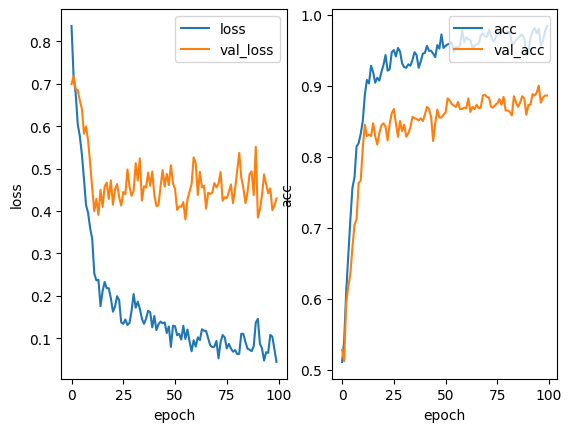

In [17]:
utils.plot_history(history, ('loss', 'acc'));

In [211]:
transformer_model.evaluate(X_test, y_test, return_dict=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.7051 - acc: 0.8025


{'loss': 0.7051464319229126, 'acc': 0.8025000095367432}

## Abstractor

In [247]:
from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import RelationalAbstracter
from abstractor import Abstractor

def create_abstractor(encoder_kwargs, abstractor_kwargs, embedding_dim, dropout_rate=0.1, name='abstractor'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    # pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    if encoder_kwargs:
        encoder = Encoder(**encoder_kwargs, name='encoder')
    # abstractor = RelationalAbstracter(**abstractor_kwargs, name='abstractor')
    abstractor = Abstractor(**abstractor_kwargs, name='abstractor')
    flattener = layers.Flatten()
    # hidden_dense = layers.Dense(64, activation='relu', name='hidden_dense')
    final_layer = layers.Dense(2, name='final_layer')

    x = source_embedder(inputs)
    # x = pos_embedding_adder_input(x)
    if encoder_kwargs:
        x = encoder(x)
    abstract_states = abstractor(x)
    x = flattener(abstract_states)
    # x = hidden_dense(x)
    logits = final_layer(x)

    abstractor_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return abstractor_model

In [248]:
abstractor_kwargs = dict(num_layers=1, rel_dim=4, symbol_dim=None,
    proj_dim=64//4, dff=128, symmetric_rels=True, encoder_kwargs=None,
    rel_activation_type='linear', use_self_attn=False, use_layer_norm=False,
    dropout_rate=0.1)

abstractor_model_kwargs = dict(encoder_kwargs=None, abstractor_kwargs=abstractor_kwargs, embedding_dim=64)
abstractor_model = create_abstractor(**abstractor_model_kwargs)

In [249]:
for train_size in [100,200,400,600,1000,2000,3000]:
    abstractor_model_kwargs = dict(encoder_kwargs=None, abstractor_kwargs=abstractor_kwargs, embedding_dim=64)
    abstractor_model = create_abstractor(**abstractor_model_kwargs)
    abstractor_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    history =  abstractor_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, callbacks=create_callbacks())
    abstractor_model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.1486 - acc: 0.9725


In [177]:
train_size = 1000
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=200, verbose=1, callbacks=create_callbacks())

Epoch 1/200


/home/mohamed/.local/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 1s 8ms/step - loss: 0.7526 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6933 - acc: 0.4890 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6932 - acc: 0.4890 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6932 - acc: 0.4890 - val_loss: 0.6931 - val_acc: 0.4980
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6931 - acc: 0.5110 - val_loss: 0.6932 - val_acc: 0.4980
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6931 - acc: 0.5110 - val_loss: 0.6932 - val_acc: 0.4980
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6930 - acc: 0.5110 - val_loss: 0.6932 - val_acc: 0.4980
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6930 - acc: 0.5110 -

## CorelNet

In [226]:
from multi_head_relation import MultiHeadRelation

def create_corelnet(embedding_dim, activation='softmax', name='corelnet'):
    inputs = layers.Input(shape=object_seqs_train.shape[1:], name='input_seq')
    object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
    source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
    activation = layers.Softmax(axis=1) if activation == 'softmax' else layers.Activation(activation)
    mhr = MultiHeadRelation(rel_dim=1, proj_dim=None, symmetric=True, dense_kwargs=dict(use_bias=False))
    flattener = layers.Flatten()
    final_layer = layers.Dense(2, name='final_layer')

    x = source_embedder(inputs)
    x = mhr(x)
    x = activation(x)
    x = flattener(x)
    logits = final_layer(x)

    corelnet_model = tf.keras.Model(inputs=inputs, outputs=logits, name=name)
    return corelnet_model

In [227]:
corelnet_model_kwargs = dict(embedding_dim=64, activation='softmax')
corelnet_model_nosoftmax_kwargs = dict(embedding_dim=64, activation='linear')
corelnet_model = create_corelnet(**corelnet_model_nosoftmax_kwargs)
corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
corelnet_model(X_train[:32]); # build
corelnet_model.summary()
for train_size in [100,200,400,600,1000,2000,3000]:
    corelnet_model_kwargs = dict(embedding_dim=64, activation='softmax')
    corelnet_model = create_corelnet(**corelnet_model_nosoftmax_kwargs)
    corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    X_train_ = X_train[:train_size]
    y_train_ = y_train[:train_size]
    history =  corelnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=0, callbacks=create_callbacks())
    corelnet_model.evaluate(X_test, y_test)

Model: "corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 3, 64)]           0         
                                                                 
 source_embedder (TimeDistr  (None, 3, 64)             4160      
 ibuted)                                                         
                                                                 
 multi_head_relation_2 (Mul  (None, 3, 3, 1)           4096      
 tiHeadRelation)                                                 
                                                                 
 activation_2 (Activation)   (None, 3, 3, 1)           0         
                                                                 
 flatten_118 (Flatten)       (None, 9)                 0         
                                                                 
 final_layer (Dense)         (None, 2)                 20 

## Learning Curves

In [29]:
from tqdm import tqdm, trange

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
class BipolarDenseLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(BipolarDenseLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros",
                                 trainable=True)

    def call(self, inputs, training=False):
        weights = tf.math.sign(self.w)
        output = tf.matmul(inputs, weights) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output
class HDSymbolicAttention(Layer):
    def __init__(self, d_model,dim, **kwargs):
        super(HDSymbolicAttention, self).__init__(**kwargs)
        self.d_model = d_model  # Dimensionality of the model
        self.dim = dim
    

    def cosine_similarity(self, a, b):
        # Compute the cosine similarity as dot product divided by magnitudes
        dot_product = tf.reduce_sum(tf.math.sign(a) * tf.math.sign(b), axis=-1)/1024
        return dot_product   
    
    
    def create_cosine_similarity_matrix(self,X):
        X_expanded = tf.expand_dims(X, 2)  # Shape: (batch_size, N, 1, D)
        X_repeated = tf.repeat(X_expanded, repeats=tf.shape(X)[1], axis=2)  # Shape: (batch_size, N, N, D)
    
        X_i_expanded = tf.expand_dims(X, 1)  # Shape: (batch_size, 1, N, D)
        X_i_repeated = tf.repeat(X_i_expanded, repeats=tf.shape(X)[1], axis=1)  # Shape: (batch_size, N, N, D)
    
        X_i_plus_X_j = X_i_repeated + X_repeated  # Broadcasting adds the matrices element-wise
    
        S = self.cosine_similarity(X_i_repeated, X_i_plus_X_j)  # Shape: (batch_size, N, N)
    
        return tf.nn.softmax(S)
            
    def build(self, input_shape):
        
                                                                         
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.Symbols = tf.Variable(
                normal_initializer(shape=(3, 64)),
                name='symbols', trainable=True)          
        self.dropout= layers.Dropout(0.05)
        #self.dense_layers = [layers.Dense(self.d_model,activation='swish',trainable=True,kernel_initializer="glorot_uniform") for _ in range(self.dim)]
        self.dense_layers = [BipolarDenseLayer(self.d_model, activation='tanh') for _ in range(self.dim)]
        self.bn1 = layers.BatchNormalization(synchronized=True)
        super(HDSymbolicAttention, self).build(input_shape)
    def call(self, values):
    
        # Unpack the inputs (queries, keys, values)
        self.S3 = tf.zeros_like(values)
        self.S3 = self.S3 + self.Symbols 
        h_vectors = [self.dense_layers[i](values[:, i, :]) for i in range(len(self.dense_layers))]
        h_vectors2 = [self.dense_layers[i](self.S3[:, i, :]) for i in range(len(self.dense_layers))]
        values_projected = tf.stack(h_vectors, axis=1)
        symbol_projected = tf.stack(h_vectors2, axis=1)
        scores  = self.create_cosine_similarity_matrix(values_projected)
        attention_output = tf.einsum('bij,bkk->bkj', values_projected, scores) 
        return  tf.nn.swish(attention_output * symbol_projected)    
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.d_model)
        

In [291]:
embedding_dim = 64
D = 1000
encoder_kwargs=dict(use_bias=True)
ordertransformer_kwargs = dict(embedding_dim=embedding_dim, encoder_kwargs=encoder_kwargs)

class LARS_VSA(tf.keras.Model):
    def __init__(self, embedding_dim, encoder_kwargs, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.encoder = HDEncoder(embedding_dim,D)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
        self.mha = HDSymbolicAttention(1000)
    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.mha([x,x,x])
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs, name=self.name).summary())


transformer_model = LARS_VSA(**ordertransformer_kwargs, name='rmts_transformer')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
transformer_model(X_train[:512])
transformer_model.print_summary((3,64))
for train_size in [100,200,400,600,1000,2000,3000]:
    transformer_model = LARS_VSA(**ordertransformer_kwargs, name='rmts_transformer')
    transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
    history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=100, batch_size=64,verbose=0)
    transformer_model.evaluate(X_test, y_test)

Model: "rmts_transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_86 (InputLayer)       [(None, 3, 64)]              0         []                            
                                                                                                  
 dense_341 (Dense)           (None, 3, 64)                4160      ['input_86[0][0]']            
                                                                                                  
 simplified_multi_head_atte  (None, 1000)                 64012     ['dense_341[0][0]',           
 ntion_99 (SimplifiedMultiH                                          'dense_341[0][0]',           
 eadAttention)                                                       'dense_341[0][0]']           
                                                                                   